In [10]:
try:
    from google.colab import drive
    !git clone https://github.com/AllexFrolov/RL-single-pong.git
except:
    pass

In [11]:
import random

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
%matplotlib inline
from importlib import reload
import dqn_agent
import wrapper
wrapper = reload(wrapper)
dqn_agent = reload(dqn_agent)
from dqn_agent import DQNAgent

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 


In [13]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [14]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.reshape(batch_size, -1)

In [15]:
class Policy(nn.Module):
    def __init__(self, in_channels, out_size, h=210, w=160):
      super(Policy, self).__init__()
      def conv2d_size_out(size, kernel_size = 4, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
      
      self.h = h
      self.w = w
      
      convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4)), 3, 1)
      convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4)), 3, 1)
      linear_input = convh * convw * 64
      self.act = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
                               nn.BatchNorm2d(32),
                               nn.ReLU(),
                               nn.Conv2d(32, 64, kernel_size=4, stride=2),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.Conv2d(64, 64, kernel_size=3, stride=1),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               Flattener(),
                               nn.Linear(linear_input, 1000),
                               nn.ReLU(),
                               nn.Linear(1000, out_size)
                               )
        
    def forward(self, batch):
        if len(batch.shape) < 4:
            batch = batch.view(1, batch.shape[0], batch.shape[1], batch.shape[2])
        return self.act(batch)
    
    def get_parameters(self):
       return self.state_dict()

    def set_parameters(self, state_dict):
        self.load_state_dict(state_dict)


In [16]:
torch.cuda.empty_cache()
in_channels = 1
out_size = 3

model = Policy(in_channels, out_size, h=84, w=336).to(device)
target_model = Policy(in_channels, out_size, h=84, w=336).to(device)

In [17]:
loss_func = nn.MSELoss()
dqn = DQNAgent(model, target_model, loss_func , out_size, memory=30000, n_multi_step=2, device=device,
               double_dqn=True, transform=False, gamma=.99, epsilon_start=1.0, epsilon_end=0.05)

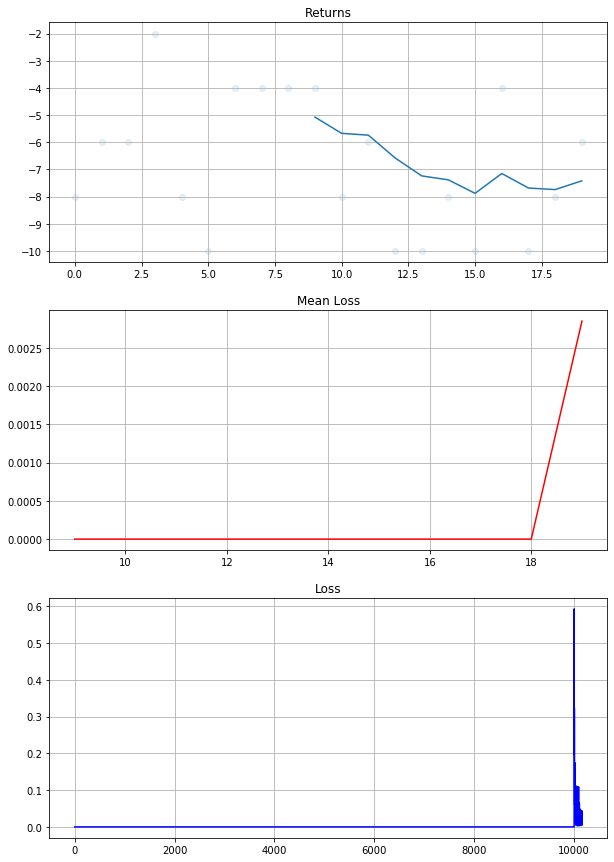

In [18]:
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
env = wrapper.make_env()
dqn.fit(env, 20, batch_size=batch_size, optimizer=optimizer,
        train_every=1, start_train_steps=10001,  update_model=1000)

In [19]:
def test_agent(env, transform=None, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
    """
    total_reward = []
    
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                agent.train(False)
                with torch.no_grad():
                    
                    if transform:
                        observation = torch.as_tensor(observation, dtype=torch.uint8)
                        observation = transform(observation)
                    probs = agent(torch.as_tensor(observation, device=device))
                    action = torch.argmax(F.softmax(probs, dim=-1)).item()
            else:
                action = random.randint(0, 2)
            observation, reward, done, state  = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
    env.stop()
    return np.mean(total_reward) 

In [21]:
# model = torch.load('model.mod')

In [22]:
env = wrapper.make_env(False, True)
test_agent(env, None, agent=model, n_episodes=2)

Episode 1 finished after 525 timesteps
Episode 2 finished after 551 timesteps


-9.0